In [1]:
import os
import io
from construct import *
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numpy as np

from IPython.display import HTML
from matplotlib import animation, rc

Set up the construct definition. 

In [2]:
filename = "./xwr16xx_processed_stream_2019_05_10T09_33_28_999.dat"
#filename = "./xwr16xx_processed_stream_2019_05_06T14_46_38_043.dat"
#filename = "./xwr16xx_processed_stream_2019_05_07T16_24_49_846.dat"
rangeFFTSize = 256
dopplerFFTSize = 256
antennas = 8

from enum import Enum
class Message(Enum):
    MMWDEMO_OUTPUT_MSG_DETECTED_POINTS = 1
    MMWDEMO_OUTPUT_MSG_RANGE_PROFILE = 2 
    MMWDEMO_OUTPUT_MSG_NOISE_PROFILE = 3
    MMWDEMO_OUTPUT_MSG_AZIMUT_STATIC_HEAT_MAP = 4
    MMWDEMO_OUTPUT_MSG_RANGE_DOPPLER_HEAT_MAP = 5
    MMWDEMO_OUTPUT_MSG_POINT_CLOUD = 6
    MMWDEMO_OUTPUT_MSG_TARGET_LIST = 7
    MMWDEMO_OUTPUT_MSG_TARGET_INDEX = 8
    MMWDEMO_OUTPUT_MSG_STATS = 9
    MMWDEMO_OUTPUT_MSG_MAX = 10
    
    
frame = Aligned(4,
    Struct(
    #Find sync bytes by looping over untill we find the magic word
    "sync" / RepeatUntil(lambda x, lst, ctx : lst[-8:] == [0x02, 0x01, 0x04, 0x03, 0x06, 0x05, 0x08, 0x07], Byte),
    "header" / Struct(
        "version" / Int32ul,
        'platform' / Int32ul, 
        'timestamp' / Int32ul,
        'totalPacketLen' / Int32ul, 
        'frameNumber' / Int32ul, 
        'subframeNumber' / Int32ul,
        'chirpProcessingMargin' / Int32ul, 
        'frameProcessingMargin' / Int32ul, 
        'trackingProcessingTime' / Int32ul,
        'uartSendingTime' / Int32ul,
        'numTLVs' / Int16ul, 
        'checksum' / Int16ul,
    ),
    "packets" / Struct(
             "type" / Int32ul,
             "len" / Int32ul,
             "data" / Switch(this.type,
                {
                Message.MMWDEMO_OUTPUT_MSG_POINT_CLOUD.value: 
                    "objects" / Struct(
                        "range" / Float32l,
                        "angle" / Float32l,
                        "doppler" / Float32l,
                        "snr" / Float32l,
                    )[lambda ctx: int((ctx.len - 8) / 16)],
                
                Message.MMWDEMO_OUTPUT_MSG_TARGET_LIST.value: 
                    "targets" / Struct(
                        "tid" / Int32ul,
                        "posx" / Float32l,
                        "posy" / Float32l,
                        "velX" / Float32l,
                        "velY" / Float32l,
                        "accX" / Float32l,
                        "accY"/ Float32l,
                        "ec" / Float32l[9],
                        "g" / Float32l,
                        "heatmap" / Float32l[100]
                    )[lambda ctx: int((ctx.len-8) / (117*4))],
                 
                Message.MMWDEMO_OUTPUT_MSG_TARGET_INDEX.value:
                    "indices" / Int8ul[this.len - 8],
                    
                Message.MMWDEMO_OUTPUT_MSG_NOISE_PROFILE.value: 
                    Array(rangeFFTSize, Int16ul),
                    
                Message.MMWDEMO_OUTPUT_MSG_AZIMUT_STATIC_HEAT_MAP.value: 
                    Array(rangeFFTSize * antennas, Struct("Img" / Int16sl, "Re" / Int16sl)),
                    
                Message.MMWDEMO_OUTPUT_MSG_RANGE_DOPPLER_HEAT_MAP.value: 
                    Array(rangeFFTSize * dopplerFFTSize, Int16ul),
                    
                Message.MMWDEMO_OUTPUT_MSG_STATS.value: 
                    Struct(
                    "interFrameProcessingTime" / Int32ul,
                    "transmitOutputTime" / Int32ul,
                    "interFrameProcessingMargin" / Int32ul,
                    "interChirpProcessingMargin" / Int32ul,
                    "activeFrameCPULoad" / Int32ul,
                    "interFrameCPULoad" / Int32ul
                ),
                }, default=Array(this.len, Byte))
         )[this.header.numTLVs] 
    )
)


Start the MMWave sensor

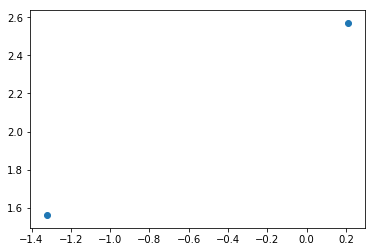

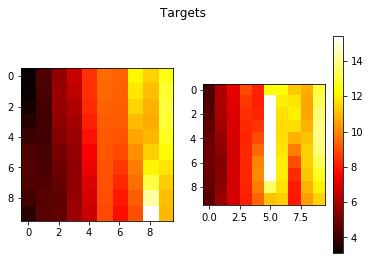

bad packet


Exception in thread Thread-21:
Traceback (most recent call last):
  File "c:\program files\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\program files\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-14-6cd09f60adf8>", line 41, in captureThreadMain
    byte = dataSerial.read(1)
  File "c:\program files\python36\lib\site-packages\serial\serialwin32.py", line 273, in read
    raise SerialException("ClearCommError failed ({!r})".format(ctypes.WinError()))
serial.serialutil.SerialException: ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

Exception in thread Thread-22:
Traceback (most recent call last):
  File "c:\program files\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\program files\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1

In [14]:
import serial
import time
import datetime
import queue
import threading
from IPython.display import clear_output

def startSensor():
    with serial.Serial("COM10",115200, parity=serial.PARITY_NONE) as controlSerial:
        with open("customchirp.cfg", 'r') as configfile:
            for line in configfile:
                #print(">> " + line)
                controlSerial.write(line.encode('ascii'))
                #print("<< " + controlSerial.readline().decode('ascii')) #echo
                print("<< " + controlSerial.readline().decode('ascii')) #"done"
                controlSerial.read(11) #prompt
                time.sleep(0.01)
            print("sensor started")

            
def matchArrays(a, b):
    if len(a) != len(b):
        return False
    
    for i in range(0, len(a)):
        if a[i] != b[i]:
            return False
    return True 

def storeThreadMain(inputqueue,stopEvent):
    with open("output.bin", "wb") as outputfile:
        while( not stopEvent.is_set()):
            packet = inputqueue.get(True, 1000)
            outputfile.write(packet)

def captureThreadMain(onPacket):
    print("Start listening on COM11")
    with serial.Serial("COM11", 921600) as dataSerial:
        buffer = []
        while(not stopEvent.is_set()):
            byte = dataSerial.read(1)
            #print(byte)
            buffer += byte
            if matchArrays([0x02, 0x01, 0x04, 0x03, 0x06, 0x05, 0x08, 0x07], buffer[-8:]):
                try:
                    onPacket(bytes(buffer))
                except StreamError:
                    print("streamerror, streamsize: {}".format(buffer))
                buffer = buffer[-8:]
                    
def parseThreadMain(inputqueue, stopEvent):
    while not stopEvent.is_set():
        rawData = inputqueue.get(True, 1000)
        if(rawData == None):
            return
        try:
            data = frame.parse(rawData)
            for packet in data['packets']:
                if packet['type'] == Message.MMWDEMO_OUTPUT_MSG_TARGET_LIST.value :
                    #print(packet['data'][0]['heatmap'])
                    targets = {}
                    for target in packet['data']:
                        target['timestamp'] = datetime.datetime.now()
                        targets[target['tid']] = target

                    #print("location x:{} y:{}".format(target['posx'], target['posy']))
                    if(len(targets) > 1):
                        clear_output()
                        images = []
                        fig, ax = plt.subplots(1, len(targets))
                        fig.suptitle('Targets')
                        i = 0
                        normalizer = matplotlib.colors.Normalize()
                        for target in targets:
                            a = np.reshape(targets[target]['heatmap'],(10,10))

                            images.append(ax[i].imshow(a, cmap='hot', norm= normalizer, interpolation='nearest'))
                            #ax[i].setTitle("x:{} y:{}".format(targets[target]['posx'], targets[target]['posy']))
                            i += 1
                        fig.colorbar(images[0])
                        plt.show()
                            #plt.imshow(a, cmap='hot', norm= matplotlib.colors.Normalize(), interpolation='nearest')
                            #plt.show()
                            #print(a)
                            
                        plt.scatter([targets[x]['posx'] for x in targets], [targets[x]['posy'] for x in targets])
        except StreamError:
            print("bad packet")
            
#Set up reading and parsing threads
writeQueue = queue.Queue()
parseQueue = queue.Queue()
stopEvent = threading.Event()

def storeAndParse(data):
    writeQueue.put(data)
    parseQueue.put(data)
    
captureThread =threading.Thread(target = captureThreadMain, args=[storeAndParse])
#writeThread = threading.Thread(target = storeThreadMain, args=[writeQueue, stopEvent])
parseThread = threading.Thread(target = parseThreadMain, args=[parseQueue, stopEvent])

#Send UART commands to start the sensor
startSensor()

#Start processing threads
captureThread.start()
#writeThread.start()
parseThread.start()


    

In [12]:
#Stop processing
stopEvent.set()
#wait for it to end
captureThread.join()
#writeThread.join()
parseThread.join() 

Exception in thread Thread-18:
Traceback (most recent call last):
  File "c:\program files\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\program files\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-4a4d70269713>", line 53, in parseThreadMain
    rawData = inputqueue.get(True, 1000)
  File "c:\program files\python36\lib\queue.py", line 172, in get
    raise Empty
queue.Empty



In [75]:
import datetime

maximages = 5
targets = {}

def handleData(data):
    for packet in data['packets']:
        if packet['type'] == Message.MMWDEMO_OUTPUT_MSG_TARGET_LIST.value :
            #print(packet['data'][0]['heatmap'])
            targets = {}
            for target in packet['data']:
                target['timestamp'] = datetime.datetime.now()
                targets[target['tid']] = target
                
            #print("location x:{} y:{}".format(target['posx'], target['posy']))
            if(len(targets) > 1):
                images = []
                fig, ax = plt.subplots(1, len(targets))
                fig.suptitle('Targets')
                i = 0
                normalizer = matplotlib.colors.Normalize()
                for target in targets:
                    a = np.reshape(targets[target]['heatmap'],(10,10))
                    
                    images.append(ax[i].imshow(a, cmap='hot', norm= normalizer, interpolation='nearest'))
                    #ax[i].setTitle("x:{} y:{}".format(targets[target]['posx'], targets[target]['posy']))
                    i += 1
                fig.colorbar(images[0])
                plt.show()
                    #plt.imshow(a, cmap='hot', norm= matplotlib.colors.Normalize(), interpolation='nearest')
                    #plt.show()
                    #print(a)

In [75]:
# startSensor()

# with open("output.bin", "wb") as outputfile:
#     with serial.Serial("COM11", 921600) as dataSerial:
#         buffer = []
#         while(True):
#             buffer += dataSerial.read(1)
#             outputfile.write(bytes(buffer[-1:]))
#             if matchArrays([0x02, 0x01, 0x04, 0x03, 0x06, 0x05, 0x08, 0x07], buffer[-8:]):
#                 try:
#                     data = frame.parse(bytes(buffer))
#                     handleData(data)
#                 except StreamError:
#                     print("streamerror, streamsize: {}".format(buffer))
#                 buffer = buffer[-8:]
            
#     parser = Rebuffered(GreedyRange(frame * handleFrame),1048576)
#     parser.compile()
#     data = parser.parse_stream(dataSerial)
    
    

sensor started


SerialException: ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [ ]:

detectedobjs = []
rangeplot = []


def handleFrame(obj, ctx):
#    print(obj.packets[0].data)
    detectedobjs.append(obj.packets[0].data)
    rangeplot.append(obj.packets[1].data)
         
frame.compile()        

with open(filename, 'rb') as file:

    
    #print(file.read(100000).split(None))
#     parser = GreedyRange(frame * handleFrame)
#     parser.compile()
#     data = parser.parse_stream(file)
    

Next we plot some of the data

In [ ]:
# detectedobjs

norm = matplotlib.colors.Normalize(vmin=-10, vmax=10, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

fig, ax = plt.subplots()
scat = ax.scatter([],[],c = mapper.to_rgba([x.dopplerIdx for x in detectedobjs[0].objects]))
ax.axis([-5000,5000,0,7000])

def animate(i):
    frame = detectedobjs[i]
    scat.set_offsets([[x.x,x.y] for x in frame.objects])
    scat.set_sizes([x.peakVal for x in frame.objects ])
    scat.set_color(mapper.to_rgba([x.dopplerIdx for x in frame.objects]))
    return scat

anim = animation.FuncAnimation(fig, animate, frames=range(len(detectedobjs)))
HTML(anim.to_jshtml())
# for i in range(len(detectedobjs)):
#     ax.scatter([x.x for x in frame.objects], [x.y for x in frame.objects],c = [x.dopplerIdx for x in frame.objects], s = [x.peakVal for x in frame.objects])
#     plt.pause(0.5)
#     plt.show()
